# Code for data pipeline for reference

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.base import RegressorMixin
from sklearn.preprocessing import StandardScaler
import sklearn
import warnings
%matplotlib inline

## Background


The [dataset](https://www.kaggle.com/gunhee/koreahousedata) is a collection of house transaction records that details various information of a house and its eventual selling price. Overall there are 5891 records of transaction of different houses and 30 features. For the features 6 of them are categorical and 24 of them numeric. No values in the sample space is missing. Three features in the dataset - `YrSold`, `MonthSold` and `SalePrice` - that describes the time and the amount of the transaction. The rest of the features in the feature space contains information for each house and their corresponding neighborhood (e.g. size, floor, how far to the nearest subway station etc).

In [5]:
# load the dataset
df = pd.read_csv('Daegu_Real_Estate_data.csv')

In [6]:
df.shape

(5891, 30)

## Methods & EDA

Our main research question is to reliably predict the housing price based on the information of the house and its neighborhood as well as what factors has the more substantial influences on the decision of the price. To do so we would perform a **linear regression** on the dataset. We would designate the feature `SalePrice` to be our target variable and all the features that describe the house sold (which is all the rest of the features save for `YrSold` and `MonthSold`). This is a regressional analysis because the target variable is, for all intents and purposes, continuous, and weights of a linear regression model shines light on the importance of the features.

For some exploratory analysis we first found the **high correlation** among all the training features that **describes the number of particular type of facility around a house**. This observation is not surprising because urban infrastructures do tend to clutter around each other. The high correlation raises concern on the **high multicollinearity** among features in our training set. We would only note this observation and leave these features as it is in our prediction task.

We then focused around the relationship of price of the house with years built and size. From price vs year we can see that there is a scant positive correlation betweeen the two variable. Additionally the distribution of price *per year* is *approximately* normal given how close the mean and medians are for each year (with the exception of 2013 where the distribution is right-skewed). The overall trend seems to indicate that the newer the house the higher the potential price (mximum likely price) the house can have.

For price vs size we see quite a clear trend of increase as well as variability in price per increase in size. More specifically, the correlation coeefficient between the two featue is around 0.7.

In [7]:
# X is our predictor variable and y is our target variable
X = df.drop(['SalePrice', 'YrSold','MonthSold'], axis = 1)
y = df['SalePrice']

In [105]:
# the first 3 pair of columns in our filtered high_correlation matrix
for elem in filter_corr(df)[:3]:
    print(elem) 

['N_Parkinglot(Basement)', 'N_FacilitiesInApt', 0.8356220993324773]
['N_FacilitiesNearBy(PublicOffice)', 'N_FacilitiesNearBy(Total)', 0.8909583372889376]
['N_FacilitiesNearBy(Dpartmentstore)', 'N_FacilitiesNearBy(Park)', 0.7742769640726073]


Text(0.5, 1.0, 'price vs age of builing')

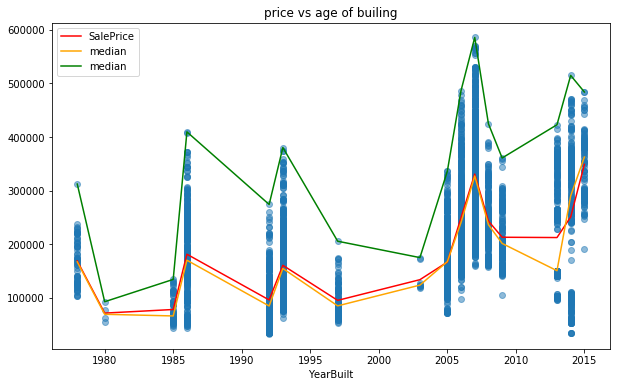

In [8]:
# Interested in how price differed w.r.t. the year built of the house
plt.figure(figsize=(10,6))
plt.scatter(X['YearBuilt'], y, alpha = 0.5)
df.groupby('YearBuilt')['SalePrice'].mean().plot(color = 'red', )
df.groupby('YearBuilt')['SalePrice'].median().plot(color = 'orange', label='median')
df.groupby('YearBuilt')['SalePrice'].max().plot(color = 'green', label='median')
plt.legend()
plt.title(f'price vs age of builing')

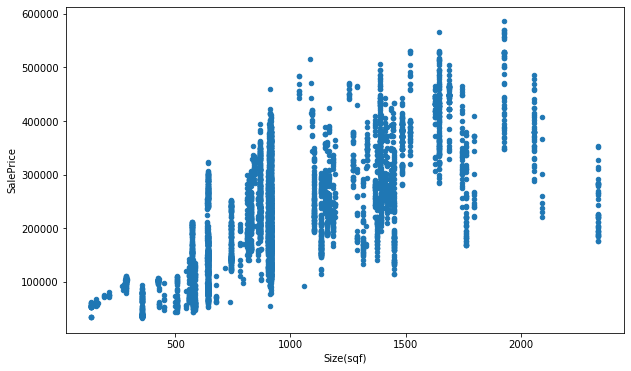

In [9]:
df[['Size(sqf)', 'SalePrice']].plot(kind='scatter', x='Size(sqf)', y='SalePrice', figsize=(10,6))

In [41]:
# Let's look at the correlation between some current predictor variables and target variables
numerical_variables = ['Size(sqf)', 'Floor', 'N_FacilitiesNearBy(Total)', 'YearBuilt']
for column in numerical_variables:
    print(column, "and price:", np.round(np.corrcoef(X[column], y)[0][1], 2))

Size(sqf) and price: 0.7
Floor and price: 0.34
N_FacilitiesNearBy(Total) and price: -0.42
YearBuilt and price: 0.45


# Results

The feature weights are way too long to be included in a markdown. Since the equation is explicitly asked for, our model is $F(X) = Xw^T$ where w is a $1\times n$ vector of values included in the column importance in the LONG dataframe in the next cell. We also measured the MSE and R2 score between the training set and the testing set. Moreoever, our model displays little bias due to the homoscedasticity displayed in the residual plot.

An additional note is that we normalized all the quantitative features to standard scale in order to normalize the innate difference in magnitude among features that describes different aspects of the house. 

In [69]:
cat_col = ['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation']
# Split the data into training and testing data
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=20)
# create two pipeline in which one does not standard scales the value and the other does
pl = train_model(train_X, train_y, cat_col, scale=True)

C:\Users\shuto\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Transformer std (type StandardScaler) does not provide get_feature_names. Will return input column names if available


In [70]:
# feature importance
fw = pd.DataFrame(zip(pl[1].trans_feature_names, pl[1].weights), columns=['feature', 'importance'])
fw.loc[44] = ['offset', pl[1].b]
fw

,feature,importance
0,onehot__x0_corridor,29803.479035
1,onehot__x0_mixed,25145.056875
2,onehot__x0_terraced,12105.902765
3,onehot__x1_central_heating,17296.192901
4,onehot__x1_individual_heating,49758.245774
5,onehot__x2_management_in_trust,-11382.363980
6,onehot__x2_self_management,78436.802655
7,onehot__x3_0~5min,81103.337928
8,onehot__x3_10min~15min,-41638.126789
9,onehot__x3_5min~10min,27589.227536


48083.077427281576 47943.63256778224


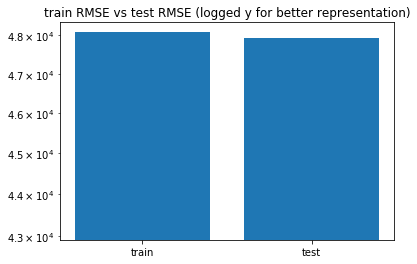

In [108]:
plot_graph(train_X, train_y, test_X, test_y)

0.7943097786632485 0.8008547173064595


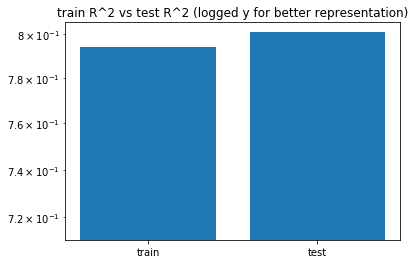

In [109]:
plot_graph(train_X, train_y, test_X, test_y, mode = 'R2')

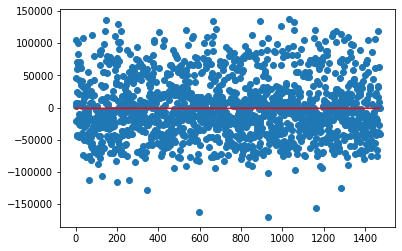

In [93]:
resid = test_y - pl.predict(test_X)
samples = range(test_X.shape[0])
plt.scatter(samples, resid)
plt.plot(samples, [resid.mean()]*len(samples), color = 'red')


# Discussion

The R2 score of the model is around 0.8, meaning that our model accounts for 80% of the variance in the target variable. The 80% threshold is a conventional criteria for passing a good enough linear regression model. Therefore for the predicatbility of the features. I believe we can conclude that the sales prices can be reliably predicted with the features given in our dataset. 

Due to the model's efficacy, we can also answer the question regarding influential factors of housing price with more confidence. We find some observations predictable while others surprising. Unsurprising discoveries include facts that 1) apartments with individual heating are more expensive than those with central heating, 2)apartments are more expensive if they are closer to bus stops. Surprising observations include the fact that 1) the apartment would be sold lower if there are too many schools around, and that 2) apartments are most expensive, by an extremely large margin, when they are slightly far away from subway stations - an apartment too close or too far would sell for a lower price. Additionally, location is a huge factor in determining house price, where a house in Sinnam raises the price for more than 60k while an apartment near a national hospital lowers the price equally in the negative direction. 

In conclusion, our analysis approach is suitable for our research goals and we have relatively high confidence in the conclusions made. 

# Appendix

* These should've been prepackaged into another file but since I can only upload a pdf I'm including them here. Bad style but w/e
* reference for get_feature_names: https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html

In [107]:
def plot_graph(train_X, train_y, test_X, test_y, mode='RMSE'):
#     plt.figure(figsize=(10, 8))
    plt.yscale('log')
    if mode == 'RMSE':
        plt.bar(['train', 'test'], [RMSE(pl.predict(train_X), train_y), RMSE(pl.predict(test_X), test_y)])
        print(RMSE(pl.predict(train_X), train_y), RMSE(pl.predict(test_X), test_y))
        plt.title('train RMSE vs test RMSE (logged y for better representation)')
    elif mode == 'R2':
        plt.bar(['train', 'test'], [pl.score(train_X, train_y), pl.score(test_X, test_y)])
        print(pl.score(train_X, train_y), pl.score(test_X, test_y))
        plt.title('train R^2 vs test R^2 (logged y for better representation)')
    
def filter_corr(df):
    cor_matrix = df.corr()
    traversed = set()
    result = []
    for column in cor_matrix.columns:
        if column not in traversed:
            current_var = cor_matrix[column]
            high_cor = current_var[(abs(current_var) > 0.75) & (abs(current_var) < 1)]
        if len(high_cor) > 0:
            for col in high_cor.index:
                traversed.add(col)
#                 print(column, "and", col, ":", '%0.2f' %high_cor[col])
                result.append([column, col, high_cor[col]])
    return result

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

def RMSE(y_pred, y):
    return np.sqrt(np.mean((y_pred - y)**2))

def train_model(X, y, cat_cols, drop_questionable=False, questionable_cols = [], scale = False):
    if drop_questionable:
        X = X.drop(questionable_cols, axis = 1)
    numeric = list(set(train_X.columns) - set(cat_col))
    if scale:
        ct = ColumnTransformer([('onehot', OneHotEncoder(), cat_col),
                                ('std', StandardScaler(), numeric)], 
                               remainder='passthrough')
    else:
        ct = ColumnTransformer([('onehot', OneHotEncoder(), cat_col)], 
                               remainder='passthrough')
    lr = COGS109_LinearRegression()
    pl = Pipeline([('ct', ct), ('lr', lr)])
    pl.fit(X, y)
    lr.trans_feature_names = get_feature_names(ct)
    return pl

class COGS109_LinearRegression(RegressorMixin):
    def __init__(self):
        self.weights = []
        self.b = None
        self.trans_feature_names = None
        
    def fit(self, X, y):
        ones = np.ones(X.shape[0]).reshape(-1,1)
        X = np.hstack([X, ones])
        weights = np.linalg.lstsq(X, y, rcond=None)[0]
        self.weights = weights[:-1]
        self.b = weights[-1]
    
    def predict(self, X):
        weights = np.hstack([self.weights, self.b])
        X = np.hstack([X, np.ones(X.shape[0]).reshape(-1, 1)])
        return np.matmul(X, weights).reshape(-1)